# Artificial Intelligence II: Project 1
### Sentiment Classification using Logistic Regression
> Fall Semester 2022-2023

> Stylianos Oikonomou | 1115201500243

## Import Libraries

In [19]:
import requests
import io
import re
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Model
from sklearn.linear_model import LogisticRegression
# Scoring
from sklearn.metrics import f1_score, recall_score, precision_score
# Stopwords
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
# General
pd.set_option('max_colwidth', 10000)
# Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
import sklearn
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Datasets

In [20]:
# Google Drive file ID from the shared link
file_id = '17K9rHy6iajoUW_IKDBwKE2LwajZzu1hV'
# Download URL for the file
download_url = f'https://drive.google.com/uc?id={file_id}'
# Fetch the content of the file
response = requests.get(download_url).content

In [21]:
# Read the content into a pandas DataFrame
dataFrames = pd.read_csv(io.StringIO(response.decode('utf-8')), sep = '\t')
# Drop the "url" column from the dataFrame
dataFrames = dataFrames.drop(["url"], axis=1)
# Change the column order for better readability
dataFrames = dataFrames.loc[:, ["review", "rating"]]

Lets take a look at the data...

In [22]:
dataFrames.head()

,review,rating
0,I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes' at the end of the movie. They were GREAT.,10.0
1,"Wagon Master is a very unique film amongst John Ford's work. Mainly because it's the only one that is based on a story written by John Ford himself, the story that was elaborated by Frank Nugent and director's son  Patrick Ford and turned into a screenplay, and because of director's personal opinion regarding it, Wagon Master is the film John Ford called the one which `came closest to being what I had wanted to achieve', to say so is not to say a little, but as Ford confessed once to Lindsay Anderson, his favourite was nonetheless My Darling Clementine and not any other.<br /><br /> Wagon Master has all ingredients one might expect to find in a John Ford's film. Wonderful cast delivering his best, thou not featuring any major stars, except the most `fordian' of all actors  Ben Johnson. Very peculiar small characters, who provide an obligatory comic relief, and Wagon Master has quite a few of them such as horn blowing Sister Ledyard (Jane Darwell) in her shot but very inspired gigs. And last but not least legendary Monument Valley with John Ford's fifth passage through it after Stagecoach, My Darling Clementine, Fort Apache and She Wore a Yellow Ribbon.<br /><br /> The film starts with two friends cowboys Travis Blue (Ben Johnson) and Sandy Owens (Harry Carey Jr) being hired to be Wagon Masters or guides for a caravan of Mormon settlers who are headed to Silver Valley, a place that's for them like a promised land. On their way they are joined by a very peculiar Dr. Locksley Hall (Alan Mowbray) with two beautiful women, who are supposedly his wife and daughter and who call themselves actors. They are headed in the same direction simply because they were recently driven out of the nearest town and have no other place to go. Nothing particularly unpleasant happens till they bump into Cleggs, a dangerous family gang consisting of father and his three sons who are on the run from the Marshal of the town where they recently committed murder and bank robbery.<br /><br /> Overall Wagon Master is no more nor less than one more precious pearl in a necklace of John Ford's wonderful Westerns. A must see. 9/10<br /><br />",9.0
2,"This film has to be as near to perfect a film as John Ford made. The film is magic, a masterpiece, the reason Ford was, well Ford. If you want to know why Ford was great this one explains it.<br /><br />The photography of course is superb, black and white as black and white should be, wonderful shots, not an over the shoulder conversation in it, pure Ford, great moments, big and little. The famous ripped pants of Ward Bond. Apparently two dogs kept invading the set and fighting so Ford wanted to use them in the fighting scene, but instead of fighting one dog ran away and the other attacked Ward Bond and ripped his pants, which caused Ford no end of mirth. A whole scene around plaiting a rope. The way Ben Johnson burn then snuffs his rope, wonderful foreshadowing and anticipation of the final. Harry Carey's naive courting of Prudence. The usual ford line about being scared and not showing it. Bond's horse accidentally falling in him and its left in the film. Johnson and Bond are fantastic in that scene. Lord help any Ford actor who does not stay in character while the camera is rolling even when a horse falls on top of you.<br /><br />A couple of very sweet romances, not intruding on the whole focus, two very likable leads, not to mention for the girls, the number of times the cameras focus on Ben Johnson's rather delightful backside.<br /><br />Lots of old time stuntmen getting lines and roles, Cliff Lyons, Frank McGrath. Some wonderful character studies mostly of faces staring, all the villains and main stars. A set of villains to rival any group in any western.<br /><br />Many many Fordian shots of faces, groups, children, women, small things ha

In [23]:
# Check if there are any Null fields in the data
dataFrames.isnull().sum()

review    0
rating    0
dtype: int64

In [24]:
# Data statistics
dataFrames.describe()

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


## Clean up data

In [25]:
reviews = dataFrames.drop(["rating"], axis=1)
ratings = dataFrames.drop(["review"], axis=1)

In [26]:
def cleanReview(review) :
  review = re.sub(r'<[ a-z/]*>', ' ', review)                                   # Remove left-over HTML Tags
  review = re.sub(r'[a-zA-Z0-9]*[0-9][a-zA-Z0-9]*', ' ', review)                # Remove numbers
  review = re.sub(r'[^`\'a-zA-Z]', ' ', review)                                 # Remove all non letter
  review = re.sub(r'( [\'`]|[\'`] |`s |\'s )', ' ', review)                     # Clean apostrophe
  review = re.sub(r'\s+', ' ', review)                                          # Remove multiple white-spaces
  review = review.casefold()                                                    # Turn all letters to lower case
  review = " ".join([word for word in review.split() if word not in (stop)])    # Remove stop words
  return review

In [27]:
cleaned_reviews = reviews.applymap(cleanReview)

In [28]:
def classifyRating(rating) :
  if rating >= 7 :
    return 1
  else :
    return 0

In [29]:
classified_ratings = ratings.applymap(classifyRating)

## Vectorizing

In [30]:
vectorizer = CountVectorizer( max_features = 500 )
features = vectorizer.fit_transform(cleaned_reviews['review'][:])

## Scaling

In [31]:
scaler = preprocessing.StandardScaler(with_mean=False).fit(features)
features = scaler.transform(features)

## Split Data Sets

In [32]:
x_train, x_val, y_train, y_val = train_test_split(features, np.ravel(classified_ratings), train_size=0.8, random_state=69)
x_train, x_val

(<36006x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 1507444 stored elements in Compressed Sparse Row format>,
 <9002x500 sparse matrix of type '<class 'numpy.float64'>'
 	with 375645 stored elements in Compressed Sparse Row format>)

## Train Model

In [33]:
val_predict_scores = []
train_predict_scores = []
sample_sizes = []

model = LogisticRegression(multi_class = 'ovr', max_iter = 1000)

print(" "*20 + "validate set" + " "*6 + "train set" + "\n" + "-"*75)
for samplesize in range(1000, x_train.shape[0], 1000):

  sample_indices = random.sample(range(2, x_train.shape[0]), samplesize)
  x_train_sample = x_train[sample_indices]
  y_train_sample = y_train[sample_indices]

  model.fit(x_train_sample, y_train_sample)

  prediction_val = model.predict(x_val)
  prediction_train = model.predict(x_train_sample)

  sample_sizes.append(samplesize)
  val_predict_scores.append(f1_score(y_val, prediction_val, average='weighted'))
  train_predict_scores.append(f1_score(y_train_sample, prediction_train, average='weighted'))

  print("SampleSize = {0:<6} f1_score        : {1:<18} {2}".format(samplesize, val_predict_scores[-1], train_predict_scores[-1]))
  print("                    recall_score    : {0:<18} {1}".format(recall_score(y_val, prediction_val, average='weighted'), recall_score(y_train_sample, prediction_train, average='weighted')))
  print("                    precision_score : {0:<18} {1}".format(precision_score(y_val, prediction_val, average='weighted'), precision_score(y_train_sample, prediction_train, average='weighted')) + "\n" +"-"*75)

                    validate set      train set
---------------------------------------------------------------------------
SampleSize = 1000   f1_score        : 0.7369365415840563 1.0
                    recall_score    : 0.7369473450344368 1.0
                    precision_score : 0.7370002462858154 1.0
---------------------------------------------------------------------------
SampleSize = 2000   f1_score        : 0.7670487392653665 0.9509988724035016
                    recall_score    : 0.7670517662741613 0.951
                    precision_score : 0.7670745077898316 0.9509996477971311
---------------------------------------------------------------------------
SampleSize = 3000   f1_score        : 0.7964874991153544 0.9093160378512088
                    recall_score    : 0.7964896689624528 0.9093333333333333
                    precision_score : 0.7964966524680466 0.9094354572270337
---------------------------------------------------------------------------
SampleSize = 4000   f1

## Results

Text(0.5, 1.0, 'Logistic Regression')

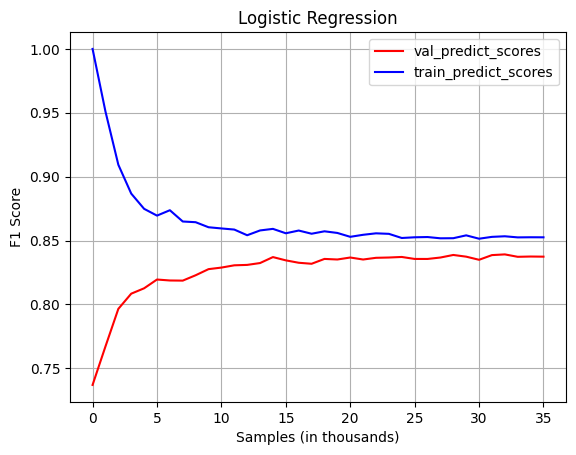

In [34]:
import matplotlib.pyplot as plt

plt.grid()
plt.xlabel('Samples (in thousands)')
plt.ylabel('F1 Score')
default_x_ticks = range(len(sample_sizes))
plt.plot(default_x_ticks, val_predict_scores, 'r', label='val_predict_scores')
plt.plot(default_x_ticks, train_predict_scores, 'b', label='train_predict_scores')
plt.legend(loc="best")
plt.title('Logistic Regression')